In [ ]:
# 1. Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
from datetime import timedelta
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset # TensorDataset untuk prediksi

warnings.filterwarnings('ignore')

# --- Parameter Data Utama ---
KODE_INDEKS = '^JKLQ45'
PERIODE_AWAL_DATA = '2005-01-01'
PERIODE_AKHIR_DATA = '2025-05-27' # Data aktual terakhir yang akan digunakan

N_FEATURES = 1 # Hanya 'Close'

# --- Parameter Model Terbaik LSTM (SESUAIKAN DENGAN MODELMU) ---
LSTM_WINDOW_SIZE = 10   # Dari nama file
LSTM_UNITS_LIST = [64, 32] # GANTI INI dengan arsitektur LSTM terbaikmu
LSTM_DENSE_UNITS = 16    # GANTI INI
LSTM_DROPOUT_RATE = 0.2  # GANTI INI
# Parameter dari nama file model (tidak dipakai untuk arsitektur jika sudah di-set di atas)
# LSTM_BEST_LR_DUMMY = 0.001
# LSTM_BEST_BS_DUMMY = 32
# LSTM_BEST_EP_SET_DUMMY = 200
LSTM_MODEL_FILENAME = "best_model_lstm_pt_w10_b32_e200_lr0001.pth"

# Direktori output tempat model disimpan
output_dir_pt = "tuning_outputs_pytorch" # Atau direktori tempat modelmu disimpan

# Tentukan device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# Rasio split data
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
# TEST_RATIO akan 0.1

Menggunakan device: cuda


In [ ]:
# 2. Definisi Kelas Model LSTM (SAMA PERSIS seperti saat training)
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_lstm_dims_list, hidden_dense_dim, output_dim, dropout_p):
        super(LSTMNet, self).__init__()
        # Gunakan nama atribut yang konsisten dengan model yang disimpan
        # Berdasarkan error sebelumnya, kemungkinan 'lstm_layers' dan 'layer_norms'
        self.lstm_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        self.dropouts_lstm = nn.ModuleList()
        current_input_dim = input_dim
        for i, h_dim in enumerate(hidden_lstm_dims_list):
            is_last_lstm_in_stack = (i == len(hidden_lstm_dims_list) - 1)
            self.lstm_layers.append(nn.LSTM(current_input_dim, h_dim, batch_first=True, num_layers=1))
            self.layer_norms.append(nn.LayerNorm(h_dim))
            self.dropouts_lstm.append(nn.Dropout(dropout_p if not is_last_lstm_in_stack else dropout_p / 2))
            current_input_dim = h_dim
        self.fc1 = nn.Linear(hidden_lstm_dims_list[-1], hidden_dense_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dense_dim, output_dim)
    def forward(self, x):
        for i in range(len(self.lstm_layers)):
            lstm_out, _ = self.lstm_layers[i](x)
            if i < len(self.lstm_layers) - 1:
                out_normalized = self.layer_norms[i](lstm_out)
                x = self.dropouts_lstm[i](out_normalized)
            else:
                out_last_step = lstm_out[:, -1, :]
                out_normalized = self.layer_norms[i](out_last_step)
                x = self.dropouts_lstm[i](out_normalized)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

print("Definisi kelas model LSTMNet selesai.")

Definisi kelas model LSTMNet selesai.


In [ ]:
# 3. Memuat Data, Preprocessing, dan Membuat Prediksi pada Test Set

print(f"\nMemproses prediksi untuk Test Set model LSTM...")

# 1. Download data
print("  Mengunduh data...")
all_data_df = yf.download(KODE_INDEKS, start=PERIODE_AWAL_DATA, end=PERIODE_AKHIR_DATA, progress=False)
if all_data_df.empty:
    raise ValueError("Gagal mengunduh data yfinance")

data_full_df = all_data_df[['Close']].copy()
data_full_df.dropna(inplace=True)
print(f"  Total data setelah dropna: {len(data_full_df)} baris")

# 2. Split data menjadi train, val, test (untuk scaler dan identifikasi test set)
train_s = int(len(data_full_df) * TRAIN_RATIO)
val_s = int(len(data_full_df) * VAL_RATIO)

train_data_df_local = data_full_df.iloc[:train_s]
# val_data_df_local = data_full_df.iloc[train_s : train_s + val_s] # Tidak dipakai untuk prediksi test
test_data_df_local = data_full_df.iloc[train_s + val_s :]

print(f"  Ukuran Train set (untuk scaler): {len(train_data_df_local)}")
print(f"  Ukuran Test set: {len(test_data_df_local)}")

if len(test_data_df_local) < LSTM_WINDOW_SIZE:
    raise ValueError(f"Data test set ({len(test_data_df_local)}) lebih kecil dari window size ({LSTM_WINDOW_SIZE}). Tidak bisa membuat sekuens.")

# 3. Siapkan scaler (fit HANYA pada data training)
scaler_lstm_test = MinMaxScaler(feature_range=(0, 1))
scaler_lstm_test.fit(train_data_df_local[['Close']])

# Scale data test
test_data_scaled = scaler_lstm_test.transform(test_data_df_local[['Close']])

# 4. Buat sekuens untuk data testing
def generate_test_sequences(scaled_data, window_size, n_features):
    x_test_seq = []
    for i in range(len(scaled_data) - window_size):
        x_test_seq.append(scaled_data[i:(i + window_size), 0])

    x_test_np = np.array(x_test_seq).reshape(-1, window_size, n_features)
    return torch.tensor(x_test_np, dtype=torch.float32)

x_test_tensor = generate_test_sequences(test_data_scaled, LSTM_WINDOW_SIZE, N_FEATURES).to(device)

# Data aktual untuk test set (yang akan dibandingkan dengan prediksi)
# Prediksi akan dimulai dari data ke-(WINDOW_SIZE) dari test_data_df_local
y_test_actual_unscaled = test_data_df_local['Close'].iloc[LSTM_WINDOW_SIZE:].values.reshape(-1,1)
# Tanggal untuk plot test set
test_dates_for_plot = test_data_df_local.index[LSTM_WINDOW_SIZE:]


# 5. Muat model LSTM terbaik
lstm_model_path = os.path.join(output_dir_pt, LSTM_MODEL_FILENAME)
preds_lstm_test_unscaled = None # Inisialisasi

if os.path.exists(lstm_model_path):
    print(f"  Memuat model LSTM dari: {lstm_model_path}")
    lstm_model_loaded_for_test = LSTMNet(
        input_dim=N_FEATURES,
        hidden_lstm_dims_list=LSTM_UNITS_LIST,
        hidden_dense_dim=LSTM_DENSE_UNITS,
        output_dim=1,
        dropout_p=LSTM_DROPOUT_RATE
    ).to(device)

    try:
        checkpoint_lstm = torch.load(lstm_model_path, map_location=device, weights_only=False)
        if isinstance(checkpoint_lstm, dict) and 'model_state_dict' in checkpoint_lstm:
            lstm_model_loaded_for_test.load_state_dict(checkpoint_lstm['model_state_dict'])
        else:
            lstm_model_loaded_for_test.load_state_dict(checkpoint_lstm)
        print("  State_dict LSTM berhasil dimuat.")

        lstm_model_loaded_for_test.eval()

        # 6. Buat prediksi pada test set
        print("  Membuat prediksi pada test set...")
        predictions_test_scaled_list = []
        with torch.no_grad():
            # Buat DataLoader sementara untuk batching jika data test besar
            temp_test_dataset = TensorDataset(x_test_tensor)
            temp_test_loader = DataLoader(temp_test_dataset, batch_size=256, shuffle=False)

            for batch_x_tensor_tuple_test in temp_test_loader:
                batch_x_tensor_test = batch_x_tensor_tuple_test[0]
                outputs_test = lstm_model_loaded_for_test(batch_x_tensor_test)
                predictions_test_scaled_list.extend(outputs_test.cpu().numpy())

        predictions_test_scaled_np = np.array(predictions_test_scaled_list)
        preds_lstm_test_unscaled = scaler_lstm_test.inverse_transform(predictions_test_scaled_np)

    except Exception as e:
        print(f"  ERROR saat memproses model LSTM: {e}")
else:
    print(f"PERINGATAN: File model LSTM {lstm_model_path} tidak ditemukan!")


Memproses prediksi untuk Test Set model LSTM...
  Mengunduh data...
YF.download() has changed argument auto_adjust default to True
  Total data setelah dropna: 4946 baris
  Ukuran Train set (untuk scaler): 3462
  Ukuran Test set: 495
  Memuat model LSTM dari: tuning_outputs_pytorch\best_model_lstm_pt_w10_b32_e200_lr0001.pth
  State_dict LSTM berhasil dimuat.
  Membuat prediksi pada test set...


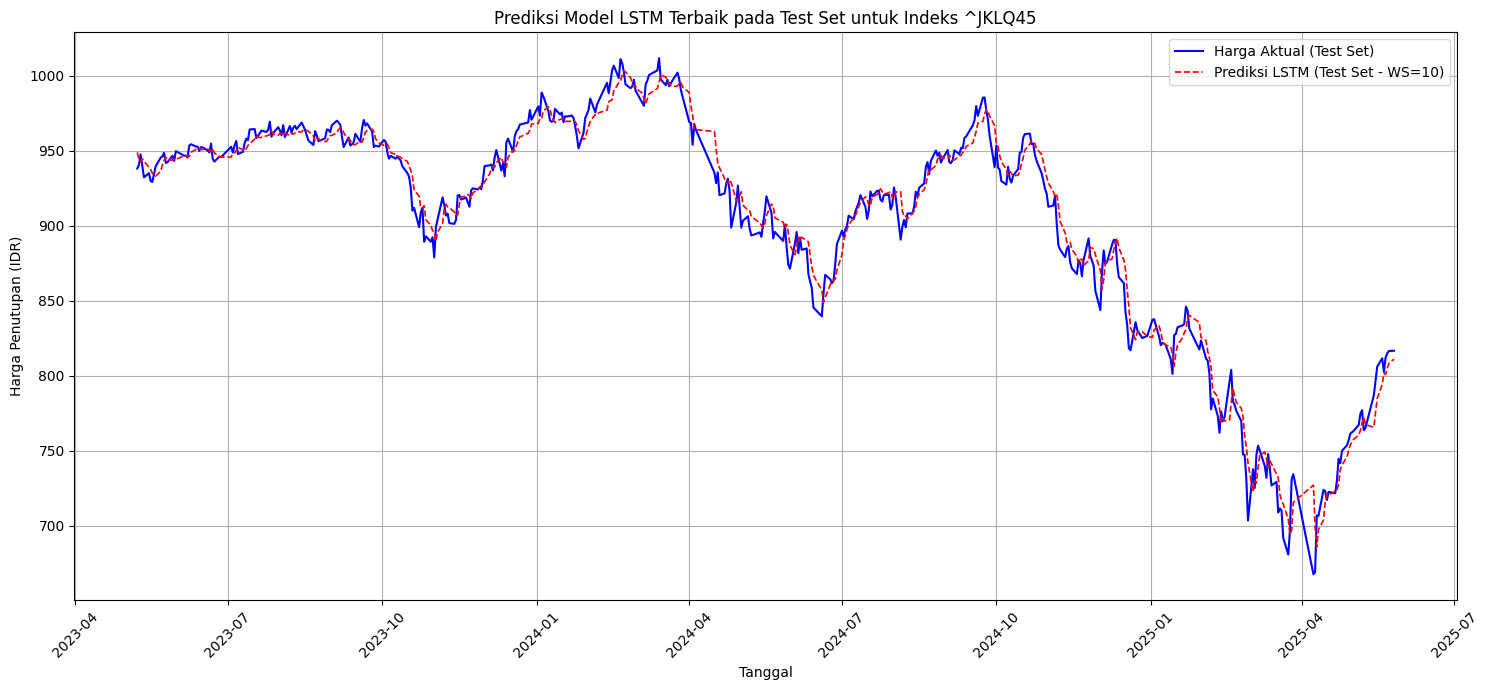


Metrik LSTM pada Test Set Aktual:
  Jumlah data test: 485
  RMSE: 10.91
  MAE : 8.24
  MAPE: 0.95%

Selesai.


In [ ]:
# 4. Plot Hasil Prediksi LSTM pada Test Set

if preds_lstm_test_unscaled is not None and y_test_actual_unscaled is not None and test_dates_for_plot is not None:
    plt.figure(figsize=(15, 7))

    plt.plot(test_dates_for_plot, y_test_actual_unscaled, label='Harga Aktual (Test Set)', color='blue', linewidth=1.5)
    plt.plot(test_dates_for_plot, preds_lstm_test_unscaled, label=f'Prediksi LSTM (Test Set - WS={LSTM_WINDOW_SIZE})', color='red', linestyle='--', linewidth=1.2)

    plt.title(f'Prediksi Model LSTM Terbaik pada Test Set untuk Indeks {KODE_INDEKS}')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan (IDR)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_pt, f'test_set_prediction_plot_lstm_{KODE_INDEKS.replace("^","")}.png'))
    plt.show()

    # Hitung metrik pada test set
    actual_test_flat = y_test_actual_unscaled.flatten()
    preds_test_flat = preds_lstm_test_unscaled.flatten()

    mse_lstm_test = mean_squared_error(actual_test_flat, preds_test_flat)
    rmse_lstm_test = math.sqrt(mse_lstm_test)
    mae_lstm_test = mean_absolute_error(actual_test_flat, preds_test_flat)

    mask_test = actual_test_flat != 0
    mape_lstm_test = np.mean(np.abs((actual_test_flat[mask_test] - preds_test_flat[mask_test]) / actual_test_flat[mask_test])) * 100 if np.sum(mask_test) > 0 else np.nan

    print(f"\nMetrik LSTM pada Test Set Aktual:")
    print(f"  Jumlah data test: {len(actual_test_flat)}")
    print(f"  RMSE: {rmse_lstm_test:.2f}")
    print(f"  MAE : {mae_lstm_test:.2f}")
    print(f"  MAPE: {mape_lstm_test:.2f}%")
else:
    print("Tidak dapat membuat plot karena prediksi LSTM pada test set gagal atau file model tidak ditemukan.")

print("\nSelesai.")